# LSTM执行多元时间序列预测

用 [feature1,feature2,feature3,feature4,target] 训练模型

为即将到来的预测目标提供4列[feature1,feature2,feature3,feature4]

In [1]:
import psutil

# 获取内存信息
memory = psutil.virtual_memory()

# 打印内存使用情况
print(f"总内存：{memory.total / 1024 / 1024} MB")
print(f"可用内存：{memory.available / 1024 / 1024} MB")
print(f"已使用内存：{memory.used / 1024 / 1024} MB")
print(f"内存使用率：{memory.percent}%")

总内存：15295.63671875 MB
可用内存：5952.4296875 MB
已使用内存：9343.20703125 MB
内存使用率：61.1%


In [56]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [182]:
df=pd.read_csv("B0018.csv")
df.head()

,循环次数,平均放电电压,平均放电温度,等压降放电时间（3.8V-3.5V）,容量
0,1,3.527546,31.773285,1559.375,1.855005
1,2,3.534836,31.924892,1581.110,1.843196
2,3,3.538247,31.316913,1582.438,1.839602
3,4,3.537698,30.821191,1572.984,1.830674
4,5,3.542668,31.953470,1592.500,1.832700


In [183]:
df.tail()

,循环次数,平均放电电压,平均放电温度,等压降放电时间（3.8V-3.5V）,容量
127,128,3.455229,31.818465,872.500,1.362737
128,129,3.461974,32.000672,858.765,1.363405
129,130,3.452222,31.739922,847.656,1.351865
130,131,3.447650,31.526136,835.906,1.354797
131,132,3.447929,31.276245,836.829,1.341051


In [184]:
df.shape

(132, 5)

In [185]:
capacity_original_half = np.array(df)[:20,4]

训练测试拆分

In [186]:
test_split=round(len(df)*0.30)
df_for_training=df[:120]
df_for_testing=df[0:]
print(df_for_training.shape)
print(df_for_testing.shape)
df_for_training

(120, 5)
(132, 5)


,循环次数,平均放电电压,平均放电温度,等压降放电时间（3.8V-3.5V）,容量
0,1,3.527546,31.773285,1559.375,1.855005
1,2,3.534836,31.924892,1581.110,1.843196
2,3,3.538247,31.316913,1582.438,1.839602
3,4,3.537698,30.821191,1572.984,1.830674
4,5,3.542668,31.953470,1592.500,1.832700
...,...,...,...,...,...
115,116,3.456915,31.310185,876.609,1.388215
116,117,3.457469,31.127360,878.954,1.376183
117,118,3.450219,30.985551,853.859,1.364717
118,119,3.448673,30.899653,854.875,1.358985


MinMax归一化

In [187]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.fit_transform(df_for_testing)
df_for_testing_scaled[1]

array([0.00763359, 0.87676438, 0.94885423, 0.98260582, 0.97702322])

In [188]:
df_for_training_scaled[0:30,0:5]

array([[0.        , 0.8059125 , 0.86990941, 0.95397123, 1.        ],
       [0.00840336, 0.87676438, 0.94885423, 0.98260582, 0.97678931],
       [0.01680672, 0.90991922, 0.632266  , 0.98435538, 0.96972587],
       [0.02521008, 0.90458638, 0.37413235, 0.97190029, 0.95217732],
       [0.03361345, 0.95289107, 0.96373551, 0.99761148, 0.95616063],
       [0.04201681, 0.97657003, 1.        , 1.        , 0.94796186],
       [0.05042017, 1.        , 0.79765806, 0.97144841, 0.93355919],
       [0.05882353, 0.97373863, 0.61731194, 0.95734651, 0.92170485],
       [0.06722689, 0.9607683 , 0.52515957, 0.95526891, 0.9003359 ],
       [0.07563025, 0.95741668, 0.53580581, 0.97898154, 0.93729178],
       [0.08403361, 0.97706976, 0.73440308, 0.96553968, 0.91572054],
       [0.09243697, 0.97587636, 0.62920044, 0.94964739, 0.90110949],
       [0.10084034, 0.96670902, 0.41202739, 0.92031455, 0.8738925 ],
       [0.1092437 , 0.93976435, 0.2280219 , 0.90316673, 0.85939956],
       [0.11764706, 0.93860643, 0.

In [189]:
df_for_training_scaled[30,4]

0.6597665490318394

将数据拆分训练集合测试集

In [190]:
# n_past是在预测下一个目标值时将在过去查看的步骤数
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past,len(dataset)):
        dataX.append(dataset[i - n_past:i,0:dataset.shape[1]])
        dataY.append(dataset[i,4])
    return np.array(dataX),np.array(dataY)

trainX , trainY = createXY(df_for_training_scaled,20)
testX , testY = createXY(df_for_testing_scaled,20)

In [191]:
print(trainX.shape)
print(trainY.shape)

print(testX.shape)
print(testY.shape)

(100, 20, 5)
(100,)
(112, 20, 5)
(112,)


In [192]:
trainY[0]

0.7572833258688161

In [193]:
testX[0]

array([[0.        , 0.8059125 , 0.86990941, 0.95397123, 1.        ],
       [0.00763359, 0.87676438, 0.94885423, 0.98260582, 0.97702322],
       [0.01526718, 0.90991922, 0.632266  , 0.98435538, 0.97003096],
       [0.02290076, 0.90458638, 0.37413235, 0.97190029, 0.95265926],
       [0.03053435, 0.95289107, 0.96373551, 0.99761148, 0.95660243],
       [0.03816794, 0.97657003, 1.        , 1.        , 0.94848628],
       [0.04580153, 1.        , 0.79765806, 0.97144841, 0.93422876],
       [0.05343511, 0.97373863, 0.61731194, 0.95734651, 0.92249388],
       [0.0610687 , 0.9607683 , 0.52515957, 0.95526891, 0.90134028],
       [0.06870229, 0.95741668, 0.53580581, 0.97898154, 0.93792373],
       [0.07633588, 0.97706976, 0.73440308, 0.96553968, 0.91656988],
       [0.08396947, 0.97587636, 0.62920044, 0.94964739, 0.90210608],
       [0.09160305, 0.96670902, 0.41202739, 0.92031455, 0.87516337],
       [0.09923664, 0.93976435, 0.2280219 , 0.90316673, 0.86081648],
       [0.10687023, 0.93860643, 0.

构建LSTM

In [194]:
learning_rate = 0.01
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(20,5)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1)

parameters = {'batch_size' : [16],
              'epochs' : [300],
              'optimizer' : ['adam'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_18732\2668548109.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1)


In [195]:
grid_search = grid_search.fit(trainX,trainY,validation_data=(testX,testY))

Epoch 1/300
4/4 [==============================] - 6s 366ms/step - loss: 0.0143 - val_loss: 0.0392
Epoch 2/300
4/4 [==============================] - 0s 39ms/step - loss: 0.0077 - val_loss: 0.0435
Epoch 3/300
4/4 [==============================] - 0s 42ms/step - loss: 0.0093 - val_loss: 0.0217
Epoch 4/300
4/4 [==============================] - 0s 40ms/step - loss: 0.0050 - val_loss: 0.0055
Epoch 5/300
4/4 [==============================] - 0s 39ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 6/300
4/4 [==============================] - 0s 42ms/step - loss: 0.0042 - val_loss: 0.0103
Epoch 7/300
4/4 [==============================] - 0s 43ms/step - loss: 0.0031 - val_loss: 0.0134
Epoch 8/300
4/4 [==============================] - 0s 42ms/step - loss: 0.0030 - val_loss: 0.0140
Epoch 9/300
4/4 [==============================] - 0s 41ms/step - loss: 0.0044 - val_loss: 0.0158
Epoch 10/300
4/4 [==============================] - 0s 40ms/step - loss: 0.0038 - val_loss: 0.0209
Epoch 11/300
4/4 [

Epoch 84/300
4/4 [==============================] - 0s 41ms/step - loss: 0.0017 - val_loss: 0.0066
Epoch 85/300
4/4 [==============================] - 0s 40ms/step - loss: 0.0014 - val_loss: 0.0053
Epoch 86/300
4/4 [==============================] - 0s 39ms/step - loss: 0.0016 - val_loss: 0.0086
Epoch 87/300
4/4 [==============================] - 0s 43ms/step - loss: 0.0018 - val_loss: 0.0092
Epoch 88/300
4/4 [==============================] - 0s 39ms/step - loss: 0.0017 - val_loss: 0.0063
Epoch 89/300
4/4 [==============================] - 0s 40ms/step - loss: 0.0016 - val_loss: 0.0086
Epoch 90/300
4/4 [==============================] - 0s 38ms/step - loss: 0.0018 - val_loss: 0.0090
Epoch 91/300
4/4 [==============================] - 0s 40ms/step - loss: 0.0013 - val_loss: 0.0087
Epoch 92/300
4/4 [==============================] - 0s 41ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 93/300
4/4 [==============================] - 0s 38ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 94/3

4/4 [==============================] - 0s 41ms/step - loss: 0.0015 - val_loss: 0.0045
Epoch 167/300
4/4 [==============================] - 0s 40ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 168/300
4/4 [==============================] - 0s 39ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 169/300
4/4 [==============================] - 0s 38ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 170/300
4/4 [==============================] - 0s 38ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 171/300
4/4 [==============================] - 0s 37ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 172/300
4/4 [==============================] - 0s 40ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 173/300
4/4 [==============================] - 0s 38ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 174/300
4/4 [==============================] - 0s 41ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 175/300
4/4 [==============================] - 0s 39ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 176/300


4/4 [==============================] - 0s 46ms/step - loss: 0.0073 - val_loss: 0.0044
Epoch 28/300
4/4 [==============================] - 0s 44ms/step - loss: 0.0086 - val_loss: 0.0065
Epoch 29/300
4/4 [==============================] - 0s 43ms/step - loss: 0.0097 - val_loss: 0.0043
Epoch 30/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0065 - val_loss: 0.0039
Epoch 31/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0089 - val_loss: 0.0037
Epoch 32/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 33/300
4/4 [==============================] - 0s 47ms/step - loss: 0.0071 - val_loss: 0.0052
Epoch 34/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0062 - val_loss: 0.0033
Epoch 35/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0070 - val_loss: 0.0031
Epoch 36/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0071 - val_loss: 0.0032
Epoch 37/300
4/4 [=====

Epoch 110/300
4/4 [==============================] - 0s 47ms/step - loss: 0.0045 - val_loss: 0.0273
Epoch 111/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0050 - val_loss: 0.0288
Epoch 112/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0048 - val_loss: 0.0288
Epoch 113/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0048 - val_loss: 0.0289
Epoch 114/300
4/4 [==============================] - 0s 47ms/step - loss: 0.0056 - val_loss: 0.0333
Epoch 115/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0045 - val_loss: 0.0368
Epoch 116/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0050 - val_loss: 0.0301
Epoch 117/300
4/4 [==============================] - 0s 47ms/step - loss: 0.0047 - val_loss: 0.0284
Epoch 118/300
4/4 [==============================] - 0s 44ms/step - loss: 0.0048 - val_loss: 0.0309
Epoch 119/300
4/4 [==============================] - 0s 47ms/step - loss: 0.0054 - val_loss: 0.0305


Epoch 192/300
4/4 [==============================] - 0s 48ms/step - loss: 0.0035 - val_loss: 0.2175
Epoch 193/300
4/4 [==============================] - 0s 49ms/step - loss: 0.0043 - val_loss: 0.2207
Epoch 194/300
4/4 [==============================] - 0s 51ms/step - loss: 0.0034 - val_loss: 0.2255
Epoch 195/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0054 - val_loss: 0.2197
Epoch 196/300
4/4 [==============================] - 0s 49ms/step - loss: 0.0037 - val_loss: 0.2066
Epoch 197/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0048 - val_loss: 0.1860
Epoch 198/300
4/4 [==============================] - 0s 43ms/step - loss: 0.0050 - val_loss: 0.1809
Epoch 199/300
4/4 [==============================] - 0s 42ms/step - loss: 0.0035 - val_loss: 0.1890
Epoch 200/300
4/4 [==============================] - 0s 47ms/step - loss: 0.0036 - val_loss: 0.1946
Epoch 201/300
4/4 [==============================] - 0s 44ms/step - loss: 0.0045 - val_loss: 0.1911


Epoch 274/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0038 - val_loss: 0.3214
Epoch 275/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0037 - val_loss: 0.2874
Epoch 276/300
4/4 [==============================] - 0s 42ms/step - loss: 0.0033 - val_loss: 0.2832
Epoch 277/300
4/4 [==============================] - 0s 44ms/step - loss: 0.0039 - val_loss: 0.2882
Epoch 278/300
4/4 [==============================] - 0s 46ms/step - loss: 0.0038 - val_loss: 0.3011
Epoch 279/300
4/4 [==============================] - 0s 42ms/step - loss: 0.0045 - val_loss: 0.3089
Epoch 280/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0038 - val_loss: 0.3045
Epoch 281/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0036 - val_loss: 0.2838
Epoch 282/300
4/4 [==============================] - 0s 44ms/step - loss: 0.0035 - val_loss: 0.2704
Epoch 283/300
4/4 [==============================] - 0s 47ms/step - loss: 0.0033 - val_loss: 0.2582


Epoch 56/300
7/7 [==============================] - 0s 28ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 57/300
7/7 [==============================] - 0s 29ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 58/300
7/7 [==============================] - 0s 28ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 59/300
7/7 [==============================] - 0s 28ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 60/300
7/7 [==============================] - 0s 31ms/step - loss: 0.0043 - val_loss: 0.0027
Epoch 61/300
7/7 [==============================] - 0s 28ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 62/300
7/7 [==============================] - 0s 30ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 63/300
7/7 [==============================] - 0s 29ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 64/300
7/7 [==============================] - 0s 30ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 65/300
7/7 [==============================] - 0s 28ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 66/3

7/7 [==============================] - 0s 28ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 221/300
7/7 [==============================] - 0s 28ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 222/300
7/7 [==============================] - 0s 27ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 223/300
7/7 [==============================] - 0s 28ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 224/300
7/7 [==============================] - 0s 30ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 225/300
7/7 [==============================] - 0s 27ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 226/300
7/7 [==============================] - 0s 27ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 227/300
7/7 [==============================] - 0s 29ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 228/300
7/7 [==============================] - 0s 28ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 229/300
7/7 [==============================] - 0s 27ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 230/300


In [196]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 300, 'optimizer': 'adam'}

In [197]:
#保存最佳模型
my_model = grid_search.best_estimator_.model

In [198]:
prediction = my_model.predict(testX)
print("prediction\n",prediction)
print("\nPrediction Shape-",prediction.shape)

4/4 [==============================] - 1s 8ms/step
prediction
 [[ 0.75694835]
 [ 0.76819587]
 [ 0.77464354]
 [ 0.78003407]
 [ 0.78503805]
 [ 0.78836364]
 [ 0.77776664]
 [ 0.7573131 ]
 [ 0.7350948 ]
 [ 0.715406  ]
 [ 0.70043385]
 [ 0.68345994]
 [ 0.6638715 ]
 [ 0.64402103]
 [ 0.63059866]
 [ 0.6206397 ]
 [ 0.60870314]
 [ 0.5977905 ]
 [ 0.587016  ]
 [ 0.57970417]
 [ 0.59493744]
 [ 0.6103608 ]
 [ 0.6230929 ]
 [ 0.6359609 ]
 [ 0.6498729 ]
 [ 0.6595971 ]
 [ 0.6751817 ]
 [ 0.682241  ]
 [ 0.68430275]
 [ 0.6826643 ]
 [ 0.6781524 ]
 [ 0.6625504 ]
 [ 0.6387184 ]
 [ 0.61298144]
 [ 0.5901704 ]
 [ 0.57079947]
 [ 0.56173205]
 [ 0.549268  ]
 [ 0.52844715]
 [ 0.5039474 ]
 [ 0.49053657]
 [ 0.47529024]
 [ 0.45958623]
 [ 0.44595885]
 [ 0.43420488]
 [ 0.42286026]
 [ 0.41474456]
 [ 0.40657666]
 [ 0.3975399 ]
 [ 0.38723394]
 [ 0.37615836]
 [ 0.35986143]
 [ 0.34152848]
 [ 0.32238322]
 [ 0.3059042 ]
 [ 0.2937346 ]
 [ 0.28547254]
 [ 0.27453387]
 [ 0.26121232]
 [ 0.25030476]
 [ 0.2440426 ]
 [ 0.24412453]
 [ 0.24

In [199]:
#逆缩放
prediction_copy = np.repeat(prediction,5,axis=-1)
pred = scaler.inverse_transform(np.reshape(prediction_copy,(len(prediction),5)))[:,4]

In [200]:
pred.shape

(112,)

In [201]:
original_copy = np.repeat(testY,5, axis=-1)
original = scaler.inverse_transform(np.reshape(original_copy,(len(testY),5)))[:,4]

In [202]:
print("Pred Values -- ",pred)
print("\nOriginal Values -- ",original)

Pred Values --  [1.7300874 1.7358681 1.7391819 1.7419524 1.7445241 1.7462335 1.740787
 1.7302748 1.7188557 1.7087365 1.7010416 1.6923178 1.6822503 1.6720481
 1.6651496 1.6600311 1.6538963 1.6482878 1.64275   1.6389922 1.6468214
 1.6547483 1.661292  1.6679054 1.6750556 1.6800535 1.6880631 1.6916913
 1.692751  1.6919088 1.68959   1.6815714 1.6693227 1.6560951 1.6443714
 1.6344155 1.6297554 1.6233494 1.6126485 1.6000568 1.5931642 1.5853283
 1.5772572 1.5702534 1.5642123 1.5583818 1.5542108 1.5500128 1.5453683
 1.5400716 1.5343791 1.5260034 1.516581  1.5067413 1.4982718 1.4920173
 1.4877709 1.4821489 1.4753023 1.4696963 1.466478  1.46652   1.4653231
 1.4625057 1.457359  1.4529947 1.4539206 1.454776  1.4556923 1.4555088
 1.4554461 1.4538108 1.4478233 1.4398928 1.4321054 1.4257528 1.4218463
 1.418582  1.4167659 1.4155548 1.4146549 1.4153959 1.4153838 1.4156201
 1.4157917 1.4153248 1.4307244 1.443508  1.4491818 1.449823  1.4469743
 1.4424319 1.4344944 1.4223279 1.4073101 1.3939087 1.3852533 1

In [203]:
original

array([1.73151667, 1.70859499, 1.71146996, 1.70750214, 1.74923821,
       1.73276972, 1.72223133, 1.7118463 , 1.69926783, 1.69403664,
       1.68190271, 1.67697706, 1.66552293, 1.65719246, 1.64822416,
       1.63877015, 1.62764869, 1.6221537 , 1.61400665, 1.67605161,
       1.64930064, 1.63238299, 1.61641597, 1.61090284, 1.59546387,
       1.72670744, 1.71656739, 1.69582356, 1.67777832, 1.66065869,
       1.66641093, 1.64683362, 1.62576399, 1.61215774, 1.60573668,
       1.67364531, 1.64043486, 1.61326533, 1.59209643, 1.58660118,
       1.58007665, 1.5641733 , 1.55561827, 1.54020453, 1.5321613 ,
       1.53162324, 1.52225959, 1.50652671, 1.50142196, 1.49635341,
       1.5334262 , 1.52384527, 1.5011921 , 1.49241767, 1.48332385,
       1.48073768, 1.47350778, 1.46801929, 1.45809236, 1.4478661 ,
       1.45278088, 1.44253564, 1.43927129, 1.42864757, 1.42490268,
       1.46981153, 1.45258197, 1.4428342 , 1.42837606, 1.41545478,
       1.45457667, 1.42831796, 1.41970269, 1.41556066, 1.40568

In [204]:
capacity_original_complete = np.append(capacity_original_half,original)
pred_complete = np.append(capacity_original_half,pred)

In [205]:
capacity_original_complete.shape
pred_complete.shape

(132,)

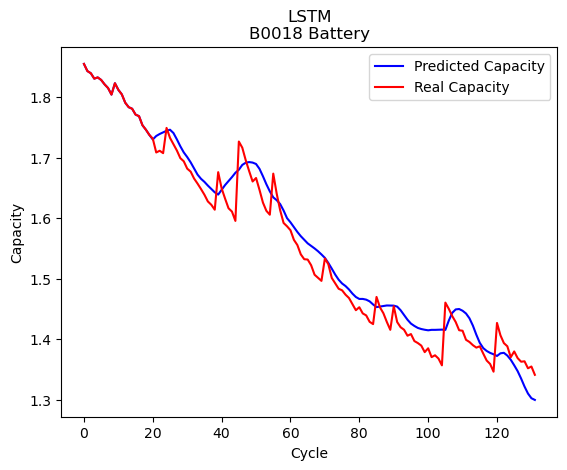

In [208]:
plt.plot(pred_complete,color = 'blue',label = 'Predicted Capacity')
plt.plot(capacity_original_complete,color = 'red',label = 'Real Capacity')
plt.title('LSTM\nB0018 Battery')
plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.legend()
plt.show()

In [209]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("mean_absolute_error MAE:", mean_absolute_error(original, pred))
print("mean_squared_error MSE:", mean_squared_error(original, pred))
print("rmse:", sqrt(mean_squared_error(original, pred)))
print("r2 score:", r2_score(original, pred))


mean_absolute_error MAE: 0.02569148213348116
mean_squared_error MSE: 0.0008643619264801281
rmse: 0.029400032763249227
r2 score: 0.9434554044423867


# 预测未来值

In [153]:
df

,循环次数,平均放电电压,平均放电温度,等压降放电时间（3.8V-3.5V）,容量
0,1,3.522007,32.624859,1643.235,1.891052
1,2,3.531949,32.738210,1682.079,1.880637
2,3,3.534403,32.685115,1682.610,1.880663
3,4,3.534925,32.554749,1702.015,1.880771
4,5,3.534537,32.467878,1701.078,1.879451
...,...,...,...,...,...
163,164,3.462081,32.463896,946.094,1.406171
164,165,3.457878,32.556814,936.735,1.406336
165,166,3.461591,32.576296,927.063,1.400455
166,167,3.462906,32.818049,964.828,1.421787


In [ ]:
df_cycles_past = df.iloc[79:99,:]
df_cycles_past

In [ ]:
df_cycle_future=pd.read_csv("B5_test1.csv",encoding = 'gb2312')
df_cycle_future

In [ ]:
df_cycle_future["容量"] = 0

In [ ]:
df_cycle_future

In [ ]:
#剔除预测数据中容量列，归一化缩放，拼接20个预测输入和88个test点
df_cycle_future = df_cycle_future[["循环次数","平均放电电压","平均放电温度","等压降放电时间","容量"]]
old_scaled_array = scaler.transform(df_cycles_past)
new_scaled_array = scaler.transform(df_cycle_future)
new_scaled_df = pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,4] = np.nan
full_df = pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

In [ ]:
full_df.loc[22]

In [ ]:
len(full_df.values)

In [ ]:
#滚动填充容量数据预测
full_df_scaled_array = full_df.values
all_data = [] #预测值
time_step = 20
for i in range(time_step,len(full_df_scaled_array)):
    data_x = []
    data_x.append(
     full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
    data_x = np.array(data_x)
    prediction = my_model.predict(data_x)
    print(prediction)
    all_data.append(prediction)
    full_df.iloc[i,4] = prediction

In [ ]:
full_df_scaled_array[0 : , 0:full_df_scaled_array.shape[1]]
full_df

In [ ]:
#逆缩放
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,5, axis=-1)
y_pred_future_cycle = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),5)))[:,4]
print(y_pred_future_cycle)

In [ ]:
df_cycle_future

# 起始点为80 预测了末尾88个容量

In [ ]:
capacity_original_half = np.array(df)[:100,4]
capacity_original_complete = np.array(df)[:,4]
len(capacity_original_half)

In [ ]:
pred_complete = np.append(capacity_original_half,y_pred_future_cycle)

In [ ]:
len(pred_complete)

In [ ]:
plt.plot(pred_complete,color = 'blue',label = 'Predicted Capacity')
plt.plot(capacity_original_complete,color = 'red',label = 'Real Capacity')
plt.title('B0005 Battery')
plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.grid()
plt.legend()
plt.show()

In [ ]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("mean_absolute_error MAE:", mean_absolute_error(original, pred))
print("mean_squared_error MSE:", mean_squared_error(original, pred))
print("rmse:", sqrt(mean_squared_error(original, pred)))
print("r2 score:", r2_score(original, pred))